# Param Scheduling

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
import sys
sys.path.insert(0, '/'.join(sys.path[0].split('/')[:-1] + ['scripts']))

from stats_logging import *

In [3]:
#export
from functools import partial

def annealer(fn):
    '''Decorator function to produce partial function of param schedule'''
    return lambda start, end: partial(fn, start, end)

@annealer
def schedule_lin(start, end, position):
    '''Linear param schedule'''
    return start + position * (end - start)

@annealer
def schedule_cos(start, end, position):
    '''Cosine param schedule'''
    return start + (1+math.cos(math.pi*(1-position))) * (end-start)/2

@annealer
def schedule_none(start, end, position):
    '''No param schedule (param values stay at start)'''
    return start

@annealer
def schedule_exp(start, end, position):
    '''Exponential param schedule'''
    return start * (end/start)**position

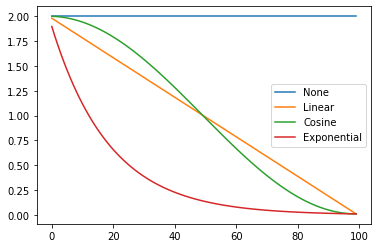

In [4]:
schedulings = [schedule_none, schedule_lin, schedule_cos, schedule_exp]
names = "None Linear Cosine Exponential".split()
a = torch.arange(0, 100)
p = torch.linspace(0.01, 1, 100)
for fn, name in zip(schedulings, names):
    f = fn(2, 1e-2)
    plt.plot(a, [f(n) for n in p], label=name)
plt.legend()

In [5]:
#export
def combine_schedules(segments, ranges):
    '''Combine multiple schedules with they respective segments and ranges'''
    assert(sum(segments) == 1.)
    segments = tensor([0] + segments)
    assert(torch.all(segments >= 0))
    segments = torch.cumsum(segments, 0)
    
    def _inner(pos):
        i = (pos >= segments).nonzero().max()
        actual_pos = (pos - segments[i]) / (segments[i+1] - segments[i])
        return ranges[i](actual_pos)
    
    return _inner

def plot_schedule(schedule):
    '''Util function for plotting param schedule'''
    a = torch.arange(0, 100)
    p = torch.linspace(0.01, 1, 100)
    plt.plot(a, [schedule(n) for n in p])

In [6]:
#export
def one_cycle_cos(start, upper, end):
    '''Wrapper function to create 1-cycle-training param schedule'''
    return [schedule_cos(start, upper), schedule_cos(upper, end)]

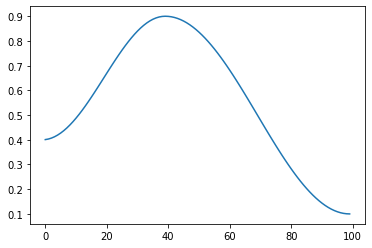

In [7]:
segments = [0.4, 0.6]
ranges = one_cycle_cos(0.4, 0.9, 0.1)
schedule = combine_schedules(segments, ranges)
plot_schedule(schedule)

In [8]:
#export
class Recorder(Callback):
    '''Callback for recording specified hyper parameters (good for debugging param scheduler)'''
    def __init__(self, param_names=['learning_rate']):
        self.parameters = {name: [] for name in param_names}
        
    def before_fit(self):
        self.losses = []
        
    def after_batch(self): 
        if not self.model.training: return
        self.losses.append(self.loss)
        for name in self.parameters:
            self.parameters[name].append(self.optimizer.hyper_params[name])       

    def plot_losses(self): 
        plt.plot(self.losses)
        plt.ylabel('loss')
        plt.xlabel('batch')
    
    def plot_parameter(self, name):
        plt.plot(self.parameters[name])
        plt.ylabel(' '.join(name.split('_')))
        plt.xlabel('batch')

In [9]:
#export
class ParamScheduler(Callback):
    '''Callback for scheduling hyper parameter value each epoch'''
    def __init__(self, param_name, schedule_fn): 
        self.param_name = param_name
        self.schedule_fn = schedule_fn
        
    def set_param(self):
        self.optimizer.hyper_params[self.param_name] = self.schedule_fn(self.iters_count / self.iters)
            
    def before_batch(self): 
        if self.model.training:
            self.set_param()

# Tests

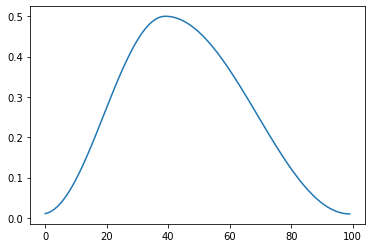

In [10]:
schedule = combine_schedules([0.4, 0.6], one_cycle_cos(0.01, 0.5, 0.01))
plot_schedule(schedule)

In [11]:
data_bunch = get_data_bunch(*get_mnist_data(), batch_size=64)
model = get_lin_model(data_bunch)
optimizer = DynamicOpt(list(model.parameters()), learning_rate=0.1)
loss_fn = CrossEntropy()
callbacks = [ParamScheduler('learning_rate', schedule), Recorder(), StatsLogging()]

In [12]:
learner = Learner(data_bunch, model, loss_fn, optimizer, callbacks)
print(learner)

(DataBunch) 
    (DataLoader) 
        (Dataset) x: (50000, 784), y: (50000,)
        (Sampler) total: 50000, batch_size: 64, shuffle: True
    (DataLoader) 
        (Dataset) x: (10000, 784), y: (10000,)
        (Sampler) total: 10000, batch_size: 128, shuffle: False
(Model)
    Linear(784, 50)
    ReLU()
    Linear(50, 10)
(CrossEntropy)
(DynamicOpt) hyper_params: ['learning_rate']
(Callbacks) ['TrainEval', 'ParamScheduler', 'Recorder', 'StatsLogging']


In [13]:
learner.fit(3)

Epoch - 1
train metrics - [0.0004405791854858398, 0.88456]
valid metrics - [2.290825843811035e-05, 0.9656]

Epoch - 2
train metrics - [3.6681375503540036e-05, 0.95666]
valid metrics - [1.053609848022461e-05, 0.968]

Epoch - 3
train metrics - [4.975547790527344e-06, 0.96464]
valid metrics - [2.3031234741210938e-06, 0.9697]



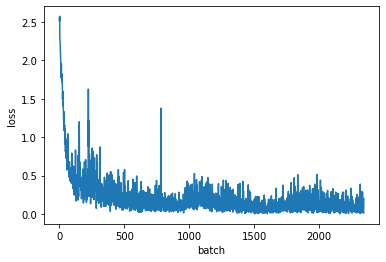

In [14]:
learner.callbacks[2].plot_losses()

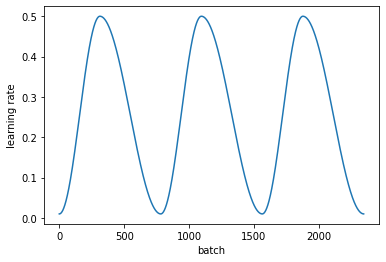

In [15]:
learner.callbacks[2].plot_parameter('learning_rate')